### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo.

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [ ]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV


import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import linregress



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pip install xgboost==1.3.3

In [ ]:
if xgb.__version__ != "1.3.3":
    os.system("pip install xgboost==1.3.3")

In [ ]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.25.2
Pandas version 1.5.3
XGBoost version 2.0.3


In [ ]:
DATA_PATH='/content/drive/MyDrive/MASTER/PANDAS_TIME_SERIES/time_series/data/'

In [ ]:

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
12385,2013-11-30,57_19597,22,57,40,19597,149.000000,1.0
10038,2014-07-31,46_16227,11,46,65,16227,419.000000,7.0
828,2013-08-31,16_2308,4,16,30,2308,649.000000,7.0
8789,2014-12-31,38_3077,10,38,23,3077,799.000000,5.0
14430,2015-06-30,7_4248,21,7,23,4248,1140.146667,4.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [ ]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido.

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u>

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [ ]:
df["unique_id"].nunique()

426

Meses aprox

In [ ]:
len(df["date"].unique())

34

In [ ]:
df.shape

(14484, 8)

Veamos cuales son las fechas min y max de nuestro dataset:

In [ ]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [ ]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [ ]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

Se pide la predicción de Octubre-2015

<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [ ]:
sample_ts = "31_4249"

In [ ]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [ ]:
df["monthly_sales"].fillna(0, inplace = True)

In [ ]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.backfill().ffill()
)

In [ ]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [ ]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [ ]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [ ]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

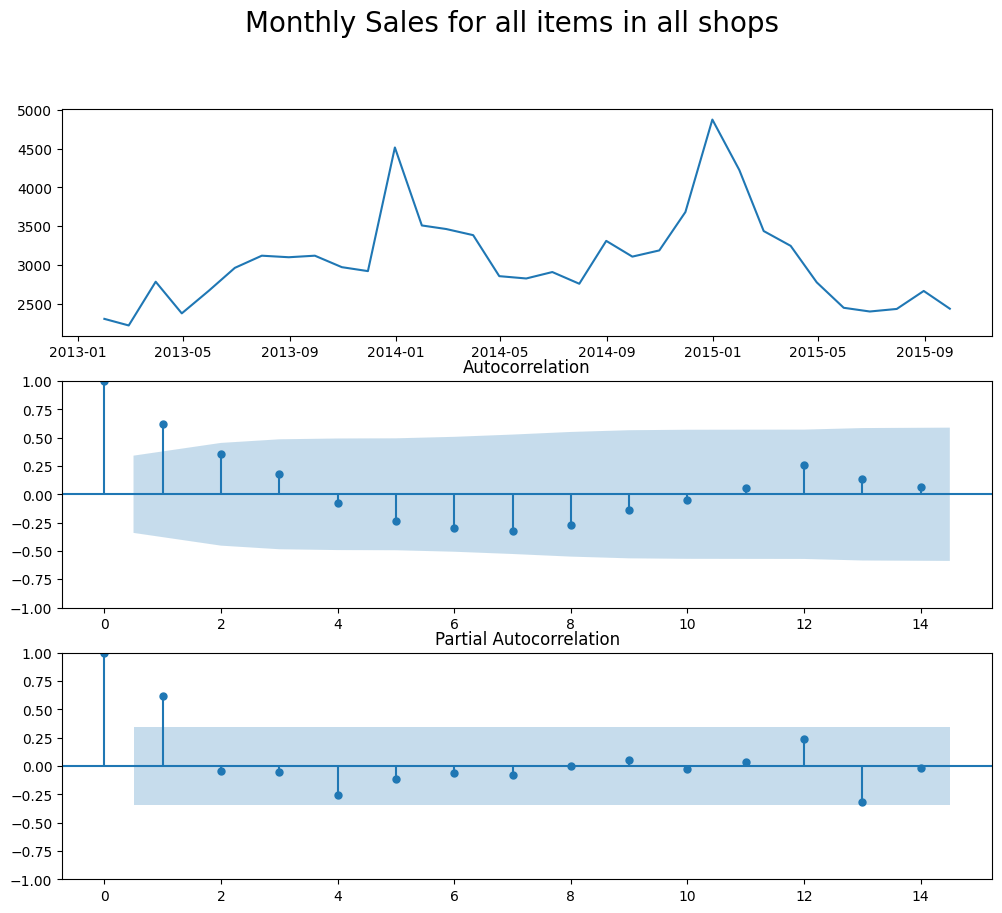

In [ ]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

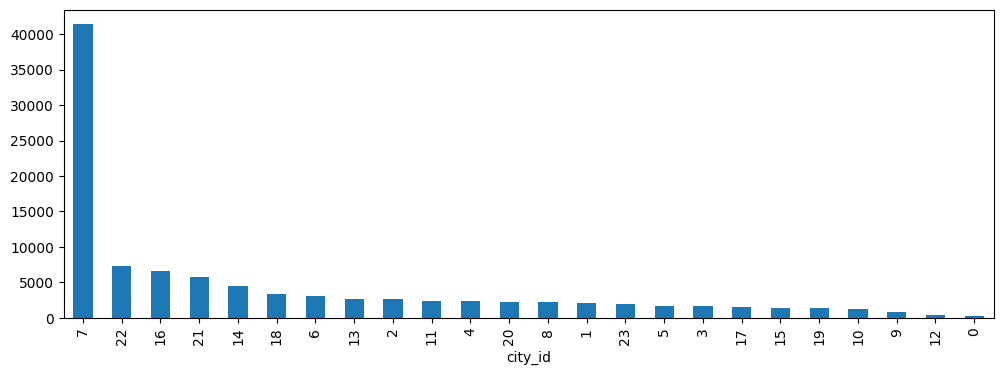

In [ ]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

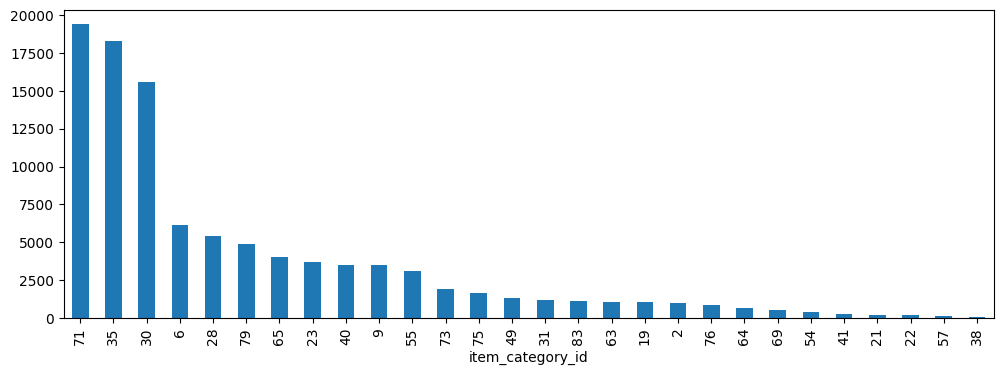

In [ ]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [ ]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, lags):
  #aseguramos que la columna date existe en df
    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    lagged_columns = [gb_df_[new_name].shift(lag).rename(f"{new_name}_lag{lag+1}") for lag in range(lags)]
    gb_df_ = pd.concat([gb_df_] + lagged_columns, axis=1)

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [ ]:
# Calcular la media móvil
def add_rolling_mean(df, target_column, window_size):
    new_column_name = f"{target_column}_rolling_mean_{window_size}"
    df[new_column_name] = df.groupby('unique_id')[target_column].transform(lambda x: x.rolling(window=window_size).mean())

    return df

In [ ]:
# Agregar la tendencia
def add_trend(df, target_column):
    df["monthly_sales_trend"] = df.groupby(["item_id"])[target_column].transform(lambda x: linregress(x.index, x).slope)

    return df

In [ ]:
# Agregar la estacionalidad
def add_seasonality(df, target_column):
    df["monthly_sales_seasonality"] = df[target_column] - df[target_column].rolling(window=3).mean()

    return df

In [ ]:
# Agrega el promedio de una categoría
def add_category_average(df, category_df, item_id_column, category_id_column, target_column):
    df_cat = df.merge(category_df.drop_duplicates([category_id_column]), how="left", on=item_id_column)
    df_cat_mean = df_cat.groupby(category_id_column)[target_column].mean().reset_index().rename(columns={target_column: f"{target_column}_category_mean"})
    df = df.merge(df_cat_mean, how="left", on=category_id_column)
    return df

In [ ]:
#Lista de columnas por las que agrupar -> GB_LIST
GB_LIST = ["item_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    lags=2

)

vars_ts_.head(10)

Dropping columns that might cause target leakage item_id_monthly_sales_sum


,item_id,date,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2
0,32,2013-01-31,24.0,NaN
1,32,2013-02-28,20.0,24.0
2,32,2013-03-31,13.0,20.0
3,32,2013-04-30,11.0,13.0
4,32,2013-05-31,6.0,11.0
5,32,2013-06-30,11.0,6.0
6,32,2013-07-31,10.0,11.0
7,32,2013-08-31,9.0,10.0
8,32,2013-09-30,2.0,9.0
9,32,2013-10-31,7.0,2.0


In [ ]:
GB_LIST_2 = ["item_id", "city_id", "shop_id"]
TARGET_COLUMN_2 = "monthly_sales"
AGG_FUNC_2 = np.sum
AGG_FUNC_NAME_2 = "sum"


vars_ts_2_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST_2,
    target_column = TARGET_COLUMN_2,
    agg_func = AGG_FUNC_2,
    agg_func_name =  AGG_FUNC_NAME_2,
    lags=1

)

vars_ts_2_.head(10)

Dropping columns that might cause target leakage item_id_city_id_shop_id_monthly_sales_sum


,item_id,city_id,shop_id,date,item_id_city_id_shop_id_monthly_sales_sum_lag1
0,32,7,31,2013-01-31,24.0
1,32,7,31,2013-02-28,20.0
2,32,7,31,2013-03-31,13.0
3,32,7,31,2013-04-30,11.0
4,32,7,31,2013-05-31,6.0
5,32,7,31,2013-06-30,11.0
6,32,7,31,2013-07-31,10.0
7,32,7,31,2013-08-31,9.0
8,32,7,31,2013-09-30,2.0
9,32,7,31,2013-10-31,7.0


In [ ]:
GB_LIST_3 = ["item_id", "city_id", "shop_id"]
TARGET_COLUMN_3 = "monthly_sales"
AGG_FUNC_3 = np.sum
AGG_FUNC_NAME_3 = "sum"


vars_ts_3_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST_3,
    target_column = TARGET_COLUMN_3,
    agg_func = AGG_FUNC_3,
    agg_func_name =  AGG_FUNC_NAME_3,
    lags=2

)

vars_ts_3_.head(10)

Dropping columns that might cause target leakage item_id_city_id_shop_id_monthly_sales_sum


,item_id,city_id,shop_id,date,item_id_city_id_shop_id_monthly_sales_sum_lag1,item_id_city_id_shop_id_monthly_sales_sum_lag2
0,32,7,31,2013-01-31,24.0,NaN
1,32,7,31,2013-02-28,20.0,24.0
2,32,7,31,2013-03-31,13.0,20.0
3,32,7,31,2013-04-30,11.0,13.0
4,32,7,31,2013-05-31,6.0,11.0
5,32,7,31,2013-06-30,11.0,6.0
6,32,7,31,2013-07-31,10.0,11.0
7,32,7,31,2013-08-31,9.0,10.0
8,32,7,31,2013-09-30,2.0,9.0
9,32,7,31,2013-10-31,7.0,2.0


In [ ]:
GB_LIST_4 = ["item_id"]
TARGET_COLUMN_4 = "monthly_average_price"
AGG_FUNC_4 = np.min
AGG_FUNC_NAME_4 = "min"


vars_ts_4_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST_4,
    target_column = TARGET_COLUMN_4,
    agg_func = AGG_FUNC_4,
    agg_func_name =  AGG_FUNC_NAME_4,
    lags=1

)

vars_ts_4_.head(10)

Dropping columns that might cause target leakage item_id_monthly_average_price_min


,item_id,date,item_id_monthly_average_price_min_lag1
0,32,2013-01-31,349.0
1,32,2013-02-28,349.0
2,32,2013-03-31,349.0
3,32,2013-04-30,349.0
4,32,2013-05-31,349.0
5,32,2013-06-30,349.0
6,32,2013-07-31,349.0
7,32,2013-08-31,349.0
8,32,2013-09-30,349.0
9,32,2013-10-31,149.0


In [ ]:
GB_LIST_5 = ["item_id"]
TARGET_COLUMN_5 = "monthly_average_price"
AGG_FUNC_5 = np.max
AGG_FUNC_NAME_5 = "max"


vars_ts_5_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST_5,
    target_column = TARGET_COLUMN_5,
    agg_func = AGG_FUNC_5,
    agg_func_name =  AGG_FUNC_NAME_5,
    lags=1

)

vars_ts_5_.head(10)

Dropping columns that might cause target leakage item_id_monthly_average_price_max


,item_id,date,item_id_monthly_average_price_max_lag1
0,32,2013-01-31,349.0
1,32,2013-02-28,349.0
2,32,2013-03-31,349.0
3,32,2013-04-30,349.0
4,32,2013-05-31,349.0
5,32,2013-06-30,349.0
6,32,2013-07-31,349.0
7,32,2013-08-31,349.0
8,32,2013-09-30,349.0
9,32,2013-10-31,149.0


In [ ]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.day_of_week


In [ ]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,month,year,day_of_week
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,1,2013,3
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2,2013,3
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,3,2013,6
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,4,2013,1
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,5,2013,4


In [ ]:
target='monthly_sales'
df = add_rolling_mean(df.copy(), target, window_size=3)
df = add_trend(df.copy(), target)



In [ ]:
df = add_seasonality(df.copy(),  target)

In [ ]:
df['monthly_sales_seasonality'].fillna(df['monthly_sales_seasonality'].mean(), inplace=True)


In [ ]:
df.head(10)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,month,year,day_of_week,monthly_sales_rolling_mean_3,monthly_sales_trend,monthly_sales_seasonality
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,1,2013,3,NaN,-0.069148,-0.001818
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2,2013,3,NaN,-0.069148,-0.001818
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,3,2013,6,29.000000,-0.069148,1.000000
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,4,2013,1,28.000000,-0.069148,-1.000000
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,5,2013,4,29.000000,-0.069148,1.000000
35,2013-06-30,12_11365,16,12,9,11365,1302.343750,28.0,6,2013,6,28.333333,-0.069148,-0.333333
42,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0,7,2013,2,26.000000,-0.069148,-6.000000
49,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0,8,2013,5,21.333333,-0.069148,-5.333333
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0,9,2013,0,20.000000,-0.069148,4.000000
63,2013-10-31,12_11365,16,12,9,11365,2493.113360,30.0,10,2013,3,23.333333,-0.069148,6.666667


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [ ]:
print(df.shape)

df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")

print(df.shape)

(14484, 14)
(14484, 16)


In [ ]:
print(df.shape)

df = pd.merge(df, vars_ts_2_, on = ["date"] + GB_LIST_2, how = "left")

print(df.shape)

(14484, 16)
(14484, 17)


In [ ]:
print(df.shape)

df = pd.merge(df, vars_ts_3_, on = ["date"] + GB_LIST_3, how = "left")

print(df.shape)

(14484, 17)
(14484, 19)


In [ ]:
print(df.shape)

df = pd.merge(df, vars_ts_4_, on = ["date"] + GB_LIST_4, how = "left")

print(df.shape)

(14484, 19)
(14484, 20)


In [ ]:
print(df.shape)

df = pd.merge(df, vars_ts_5_, on = ["date"] + GB_LIST_5, how = "left")

print(df.shape)

(14484, 20)
(14484, 21)


In [ ]:
df.head(1)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,month,year,...,monthly_sales_rolling_mean_3,monthly_sales_trend,monthly_sales_seasonality,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_city_id_shop_id_monthly_sales_sum_lag1_x,item_id_city_id_shop_id_monthly_sales_sum_lag1_y,item_id_city_id_shop_id_monthly_sales_sum_lag2,item_id_monthly_average_price_min_lag1,item_id_monthly_average_price_max_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,1,2013,...,NaN,-0.069148,-0.001818,30.0,0.0,30.0,30.0,0.0,1511.512626,1511.512626


In [ ]:
#del df['item_id_city_id_shop_id_monthly_sales_sum_lag1_y']

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [ ]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'month',
 'year',
 'day_of_week',
 'monthly_sales_rolling_mean_3',
 'monthly_sales_trend',
 'monthly_sales_seasonality',
 'item_id_monthly_sales_sum_lag1',
 'item_id_monthly_sales_sum_lag2',
 'item_id_city_id_shop_id_monthly_sales_sum_lag1_x',
 'item_id_city_id_shop_id_monthly_sales_sum_lag1_y',
 'item_id_city_id_shop_id_monthly_sales_sum_lag2',
 'item_id_monthly_average_price_min_lag1',
 'item_id_monthly_average_price_max_lag1']

In [ ]:
COLUMNS_TO_DROP = ['item_id_city_id_shop_id_monthly_sales_sum_lag1_y'
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df.set_index("unique_id", inplace = True)

In [ ]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,month,year,day_of_week,monthly_sales_rolling_mean_3,monthly_sales_trend,monthly_sales_seasonality,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_city_id_shop_id_monthly_sales_sum_lag1_x,item_id_city_id_shop_id_monthly_sales_sum_lag2,item_id_monthly_average_price_min_lag1,item_id_monthly_average_price_max_lag1
unique_id,,,,,,,,,,,,,,,,,,,
47_5823,2013-08-31,15,47,35,5823,2599.0000,1.0,8,2013,5,1.000000,0.000149,0.000000,60.0,36.0,1.0,0.0,2598.875,2599.0
31_3656,2015-10-31,7,31,55,3656,349.0000,0.0,10,2015,5,1.666667,-0.000155,-1.666667,0.0,2.0,0.0,2.0,349.000,349.0
52_16167,2015-04-30,18,52,64,16167,799.0000,2.0,4,2015,3,2.000000,-0.000339,0.000000,12.0,11.0,2.0,0.0,759.000,799.0
28_7894,2013-01-31,7,28,6,7894,1434.0625,10.0,1,2013,3,NaN,-0.000020,4.333333,120.0,0.0,10.0,0.0,1303.625,1490.0
31_7071,2013-05-31,7,31,19,7071,2499.0000,4.0,5,2013,4,13.666667,-0.000051,-9.666667,9.0,14.0,4.0,7.0,2499.000,2499.0


In [ ]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [ ]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [numpy.datetime64('2013-01-31T00:00:00.000000000'), numpy.datetime64('2013-02-28T00:00:00.000000000')] - ... - [numpy.datetime64('2015-07-31T00:00:00.000000000'), numpy.datetime64('2015-08-31T00:00:00.000000000')]

Our validation index is [numpy.datetime64('2015-09-30T00:00:00.000000000')]

Our test/prediction index is [numpy.datetime64('2015-10-31T00:00:00.000000000')]



In [ ]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [ ]:
"""#usamos gridsearch para encontrar los mejores parámetros
model_base = xgb.XGBRegressor(eval_metric="rmse", seed=175, eta=0.1)
# Definir los parámetros a ajustar
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 6, 7],
    'learning_rate': [0.05, 0.1, 0.2]

}
grid_search = GridSearchCV(estimator=model_base, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

"""

'#usamos gridsearch para encontrar los mejores parámetros\nmodel_base = xgb.XGBRegressor(eval_metric="rmse", seed=175, eta=0.1)\n# Definir los parámetros a ajustar\nparam_grid = {\n    \'n_estimators\': [300, 500, 700],\n    \'max_depth\': [4, 6, 7],\n    \'learning_rate\': [0.05, 0.1, 0.2]\n\n}\ngrid_search = GridSearchCV(estimator=model_base, param_grid=param_grid, cv=5, scoring=\'neg_root_mean_squared_error\')\n\n'

In [ ]:
"""grid_search.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valida, Y_valida)], verbose=True)"""

'grid_search.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valida, Y_valida)], verbose=True)'

In [ ]:
"""print("Mejores parámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Mejor puntaje encontrado:")
print(grid_search.best_score_)"""

'print("Mejores parámetros:", grid_search.best_params_)\nbest_model = grid_search.best_estimator_\nprint("Mejor puntaje encontrado:")\nprint(grid_search.best_score_)'

In [ ]:
best_model=xgb.XGBRegressor(eval_metric="rmse", seed=74, eta=0.05, max_depth=5, n_estimators=700,gamma=0.1,  alpha=0.1,min_child_weight=1 )
best_model

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, ...)

In [ ]:
best_model.fit( X_train, Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True,
    early_stopping_rounds = 15)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  self._le = XGBoostLabelEncoder().fit(y)


[0]	validation_0-rmse:7.51806	validation_1-rmse:7.15604
[1]	validation_0-rmse:7.14318	validation_1-rmse:6.79942
[2]	validation_0-rmse:6.78703	validation_1-rmse:6.46044
[3]	validation_0-rmse:6.44860	validation_1-rmse:6.13723
[4]	validation_0-rmse:6.12706	validation_1-rmse:5.83097
[5]	validation_0-rmse:5.82159	validation_1-rmse:5.54014
[6]	validation_0-rmse:5.53132	validation_1-rmse:5.26278
[7]	validation_0-rmse:5.25557	validation_1-rmse:5.00092
[8]	validation_0-rmse:4.99352	validation_1-rmse:4.75053
[9]	validation_0-rmse:4.74461	validation_1-rmse:4.51422
[10]	validation_0-rmse:4.50802	validation_1-rmse:4.28819
[11]	validation_0-rmse:4.28326	validation_1-rmse:4.07344
[12]	validation_0-rmse:4.06976	validation_1-rmse:3.87076
[13]	validation_0-rmse:3.86684	validation_1-rmse:3.67732
[14]	validation_0-rmse:3.67404	validation_1-rmse:3.49347
[15]	validation_0-rmse:3.49085	validation_1-rmse:3.31936
[16]	validation_0-rmse:3.31680	validation_1-rmse:3.15355
[17]	validation_0-rmse:3.15142	validation

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, ...)

In [ ]:
predictions = best_model.predict(X_test)


In [ ]:
"""from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Definir el espacio de búsqueda de parámetros
param_dist = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 8),
    'learning_rate': stats.uniform(0.05, 0.15)
}

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model_base, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

# Entrenar el modelo con RandomizedSearchCV
random_search.fit(X_train, Y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", random_search.best_params_)

# Obtener el mejor modelo
best_model_random = random_search.best_estimator_

# Hacer predicciones con el mejor modelo
predictions_random = best_model_random.predict(X_test)
"""

'from sklearn.model_selection import RandomizedSearchCV\nimport scipy.stats as stats\n\n# Definir el espacio de búsqueda de parámetros\nparam_dist = {\n    \'n_estimators\': stats.randint(100, 1000),\n    \'max_depth\': stats.randint(3, 8),\n    \'learning_rate\': stats.uniform(0.05, 0.15)\n}\n\n# Inicializar RandomizedSearchCV\nrandom_search = RandomizedSearchCV(estimator=model_base, param_distributions=param_dist, n_iter=10, cv=3, scoring=\'neg_root_mean_squared_error\', random_state=42)\n\n# Entrenar el modelo con RandomizedSearchCV\nrandom_search.fit(X_train, Y_train)\n\n# Mostrar los mejores parámetros encontrados\nprint("Mejores parámetros:", random_search.best_params_)\n\n# Obtener el mejor modelo\nbest_model_random = random_search.best_estimator_\n\n# Hacer predicciones con el mejor modelo\npredictions_random = best_model_random.predict(X_test)\n'

In [ ]:
pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Definir el espacio de búsqueda de parámetros
param_dist = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 8),
    'learning_rate': Real(0.05, 0.2, 'uniform')
}

# Inicializar BayesSearchCV
bayes_search = BayesSearchCV(estimator=model_base, search_spaces=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

# Entrenar el modelo con BayesSearchCV
bayes_search.fit(X_train, Y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", bayes_search.best_params_)

# Obtener el mejor modelo
best_model_bayes = bayes_search.best_estimator_

# Hacer predicciones con el mejor modelo
predictions_bayes = best_model_bayes.predict(X_test)


Mejores parámetros: OrderedDict([('learning_rate', 0.05054454608821149), ('max_depth', 7), ('n_estimators', 767)])


In [ ]:
"""model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175, eta=0.1)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)"""

'model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175, eta=0.1)\n\nmodel.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)'

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

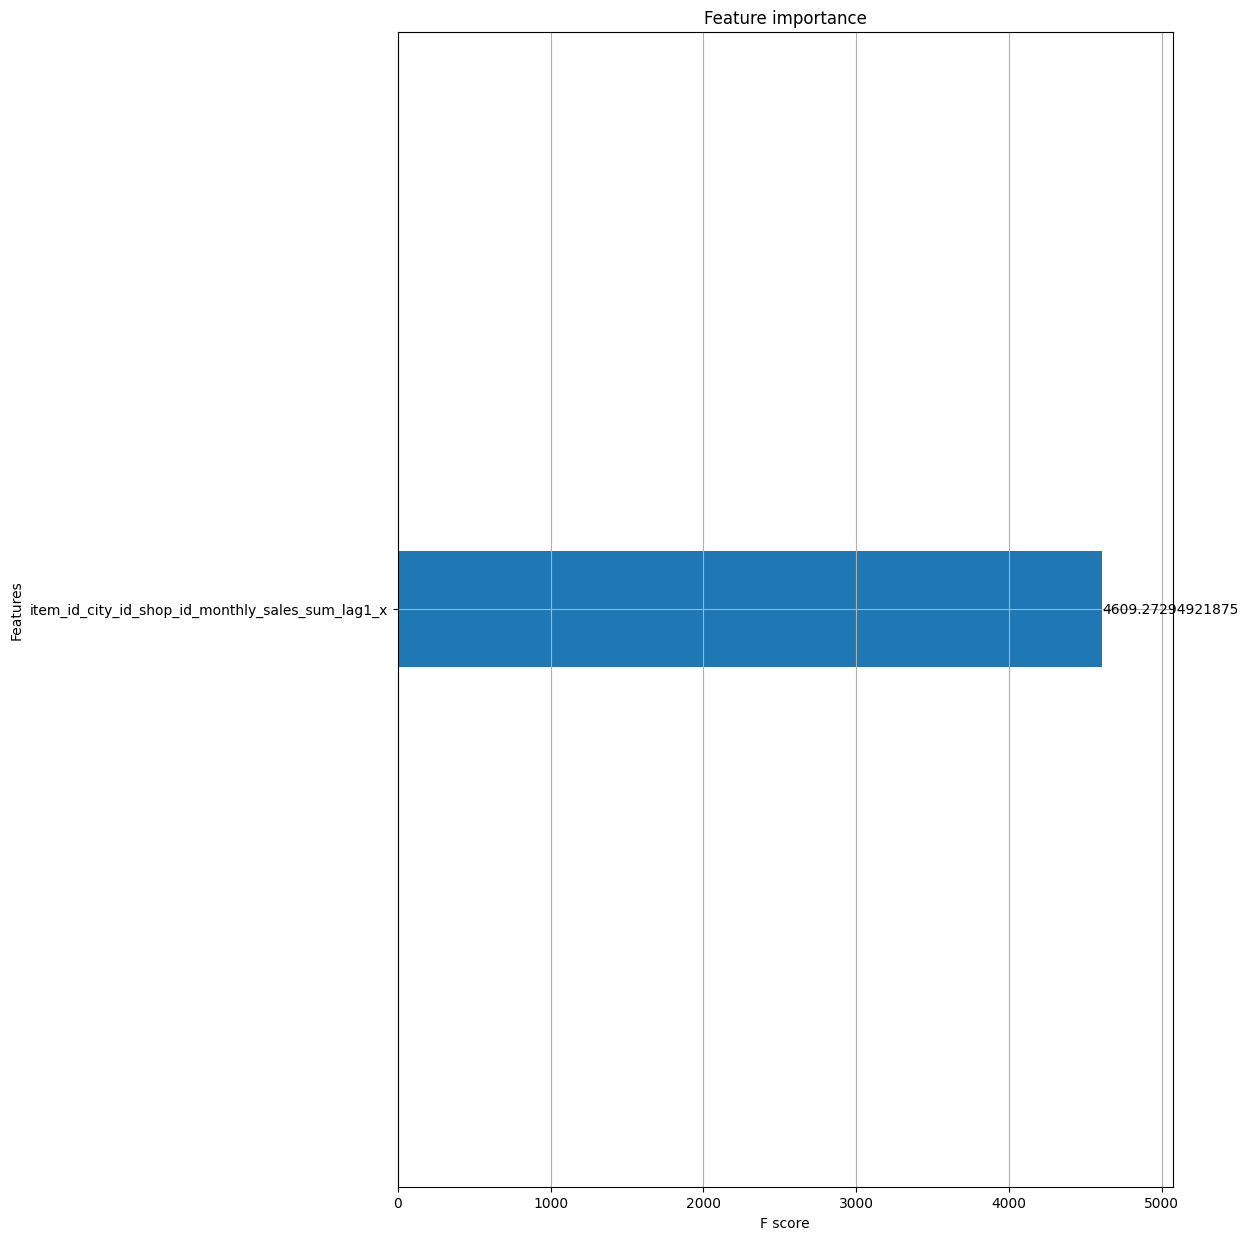

In [ ]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(best_model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [ ]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

Y_test_predict = best_model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
Y_train_predict = best_model.predict(X_train)
Y_valida_predict = best_model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 0_004
Validation RMSE: 0_003


In [ ]:
ruta_guardado = "/content/drive/MyDrive/MASTER/PANDAS_TIME_SERIES/time_series/entries/"

X_test[["unique_id", "monthly_sales"]].to_csv(
    f"{ruta_guardado}submission_train_{rmse_train}_valida_{rmse_valida}.csv",
    index=False
)


<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)